In [165]:
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42

In [166]:
class VQ(nn.Module):
    def __init__(self, num_emb, emb_dim, beta=0.25):
        super(VQ, self).__init__()
        self.num_emb = num_emb
        self.emb_dim = emb_dim
        self.beta = beta

        self.codebook = nn.Embedding(self.num_emb, self.emb_dim)
        self.codebook.weight.data.uniform_(-1 / num_emb, 1 / num_emb)

    def forward(self, input):
        # Permute from (B, C, H, W) to (B, H, W, C) and flatten to (BHW, C)
        input = input.permute(0, 2, 3, 1).contiguous()
        input_shape = input.shape
        flat_input = input.view(-1, self.emb_dim)

        # Calculate distances
        dist = torch.sum(flat_input**2, dim=1, keepdim=True) + \
            torch.sum(self.codebook.weight**2, dim=1) - \
            2 * torch.matmul(flat_input, self.codebook.weight.t())
        
        # Select closest encodings
        indices = torch.argmin(dist, dim=1).unsqueeze(1)
        encodings = torch.zeros(indices.shape[0], self.num_emb, device=input.device)
        encodings.scatter_(1, indices, 1)
        quantized = torch.matmul(encodings, self.codebook.weight).view(input_shape)

        # Get loss
        codebook_loss = F.mse_loss(quantized, input.detach())
        commitment_loss = F.mse_loss(quantized.detach(), input)
        loss = codebook_loss + self.beta * commitment_loss

        # Copy gradients from decoder to encoder
        quantized = (input + (quantized - input).detach()).permute(0, 3, 1, 2).contiguous()

        # Metrics
        avg_prob = torch.mean(encodings, dim=0)
        perp = torch.exp(-torch.sum(avg_prob * torch.log(avg_prob + 1e-10)))
        
        return quantized, loss, perp

In [167]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_hiddens):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, num_hiddens, 3, padding=1, bias=False),
            nn.BatchNorm2d(num_hiddens),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_hiddens, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.block(x) + x


class ResStack(nn.Module):
    def __init__(self, in_channels, num_res_layers, num_res_hiddens):
        super(ResStack, self).__init__()
        self.num_residual_layers = num_res_layers
        self.layers = nn.ModuleList([ResBlock(
            in_channels, in_channels, num_res_hiddens) for _i in range(num_res_layers)])

    def forward(self, x):
        for i in range(self.num_residual_layers):
            x = self.layers[i](x)
        return F.relu(x)

In [168]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_res_layers, num_res_hiddens):
        super(Encoder, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens//2, (4, 4), stride=(2, 2), padding=1), # 7, 768
            # nn.BatchNorm2d(num_hiddens//2),
            nn.ReLU(),
            nn.Conv2d(num_hiddens//2, num_hiddens, (3, 4), stride=(1, 2), padding=1), # 7, 384
            # nn.BatchNorm2d(num_hiddens),
            nn.ReLU(),
            nn.Conv2d(num_hiddens, num_hiddens, (3, 4), stride=(1, 2), padding=1), # 7, 192
            # nn.BatchNorm2d(num_hiddens),
            nn.ReLU(),
            nn.Conv2d(num_hiddens, num_hiddens, (3, 4), stride=(1, 2), padding=1), # 7, 96
            # nn.BatchNorm2d(num_hiddens),
            ResStack(num_hiddens, num_res_layers, num_res_hiddens)
        )

    def forward(self, x):
        return self.block(x)

In [169]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_res_layers, num_res_hiddens):
        super(Decoder, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens, 3, stride=1, padding=1), # 7, 96
            ResStack(num_hiddens, num_res_layers, num_res_hiddens),
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens, num_hiddens, (3, 4), stride=(1, 2), padding=1), # 7, 192
            # nn.BatchNorm2d(num_hiddens),
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens, num_hiddens, (3, 4), stride=(1, 2), padding=1), # 7, 384
            # nn.BatchNorm2d(num_hiddens),
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens, num_hiddens//2, (3, 4), stride=(1, 2), padding=1), # 7, 768
            # nn.BatchNorm2d(num_hiddens//2),
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens//2, 1, (5, 4), stride=(2, 2), padding=1), # 15, 1536
        )

    def forward(self, x):
        return self.block(x)

In [170]:
class VQVAE(nn.Module):
    def __init__(self, num_hiddens, num_res_layers, num_res_hiddens, num_emb, emb_dim, beta):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(1, num_hiddens, num_res_layers, num_res_hiddens)
        self.pre_conv = nn.Conv2d(num_hiddens, emb_dim, 1)
        self.vq = VQ(num_emb, emb_dim, beta)
        self.decoder = Decoder(emb_dim, num_hiddens, num_res_layers, num_res_hiddens)
    
    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_conv(z)
        quantized, vq_loss, perp = self.vq(z)
        recon = self.decoder(quantized)
        return recon, vq_loss, perp

In [171]:
class DrumDataset:
    def __init__(self, data_path:Path):
        self.fn_list = sorted(list(data_path.glob('*.pt')))
        assert len(self.fn_list) > 0, f'No data found in {data_path}'
        self.data = [torch.load(fn) for fn in self.fn_list]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def get_variance(self):
        return torch.var(torch.cat(self.data, dim=0))

In [172]:
def collate(batch):
    return torch.stack(batch).unsqueeze(1)

In [173]:
class Trainer:
    def __init__(self, model, optimizer, train_loader, valid_loader, device, data_variance, checkpoint_path:Path):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.device = device
        self.data_variance = data_variance
        self.checkpoint_path = checkpoint_path
        self.checkpoint_path.mkdir(exist_ok=True)

        self.start_epoch = 0
        self.train_loss_record = []
        self.train_vq_loss_record = []
        self.train_recon_loss_record = []
        self.train_perp_record = []
        self.valid_loss_record = []
        self.valid_vq_loss_record = []
        self.valid_recon_loss_record = []
        self.valid_perp_record = []

    def save_checkpoint(self, epoch, output_path:Path, prefix=''):
        now = datetime.now()
        output_path = output_path / f'{prefix}-{now.strftime("%m-%d-%H-%M")}-epoch{epoch}.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_loss_record': self.train_loss_record,
            'train_vq_loss_record': self.train_vq_loss_record,
            'train_recon_loss_record': self.train_recon_loss_record,
            'train_perp_record': self.train_perp_record,
            'valid_loss_record': self.valid_loss_record,
            'valid_vq_loss_record': self.valid_vq_loss_record,
            'valid_recon_loss_record': self.valid_recon_loss_record,
            'valid_perp_record': self.valid_perp_record,
        }, output_path)

    def load_checkpoint(self, checkpoint_path:Path):
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_loss_record = checkpoint['train_loss_record']
        self.train_vq_loss_record = checkpoint['train_vq_loss_record']
        self.train_recon_loss_record = checkpoint['train_recon_loss_record']
        self.train_perp_record = checkpoint['train_perp_record']
        self.valid_loss_record = checkpoint['valid_loss_record']
        self.valid_vq_loss_record = checkpoint['valid_vq_loss_record']
        self.valid_recon_loss_record = checkpoint['valid_recon_loss_record']
        self.valid_perp_record = checkpoint['valid_perp_record']

    def train(self, num_epochs, reset_records=False):
        self.model.to(self.device)
        if reset_records:
            self.train_loss_record = []
            self.train_vq_loss_record = []
            self.train_recon_loss_record = []
            self.train_perp_record = []
            self.valid_loss_record = []
            self.valid_vq_loss_record = []
            self.valid_recon_loss_record = []
            self.valid_perp_record = []

        for epoch in tqdm(range(self.start_epoch, num_epochs)):
            self.model.train()
            for batch in self.train_loader:
                input = batch.to(self.device)
                recon, vq_loss, perp = self.model(input)

                recon_loss = F.mse_loss(recon, input) / self.data_variance
                loss = recon_loss + vq_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                self.train_loss_record.append(loss.item())
                self.train_vq_loss_record.append(vq_loss.item())
                self.train_recon_loss_record.append(recon_loss.item())
                self.train_perp_record.append(perp.item())

            self.model.eval()
            with torch.inference_mode():
                for batch in self.valid_loader:
                    input = batch.to(self.device)
                    recon, vq_loss, perp = self.model(input)

                    recon_loss = F.mse_loss(recon, input) / self.data_variance
                    loss = recon_loss + vq_loss

                    self.valid_loss_record.append(loss.item())
                    self.valid_vq_loss_record.append(vq_loss.item())
                    self.valid_recon_loss_record.append(recon_loss.item())
                    self.valid_perp_record.append(perp.item())

In [174]:
# Hyperparameters

NUM_HIDDENS = 128
NUM_RES_LAYERS = 2
NUM_RES_HIDDENS = 32
EMB_DIM = 64
NUM_EMB = 256
BETA = 0.3
LR = 1e-3

In [175]:
RNG = torch.Generator().manual_seed(RANDOM_SEED)
base_set = DrumDataset(Path('data/converted'))
data_variance = base_set.get_variance()
train_set, valid_set = torch.utils.data.random_split(
    base_set, [0.8, 0.2], generator=RNG)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=True, generator=RNG, collate_fn=collate)
valid_loader = torch.utils.data.DataLoader(
    valid_set, batch_size=32, shuffle=False, collate_fn=collate)

model = VQVAE(NUM_HIDDENS, NUM_RES_LAYERS, NUM_RES_HIDDENS, EMB_DIM, NUM_EMB, BETA)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

trainer = Trainer(model, optimizer, train_loader, valid_loader, DEV, data_variance, Path('checkpoints'))

In [176]:
trainer.train(200)

  0%|          | 0/200 [00:00<?, ?it/s]

In [182]:
trainer.save_checkpoint(200, Path('checkpoints'), '128-2-32-64-256-0.3')

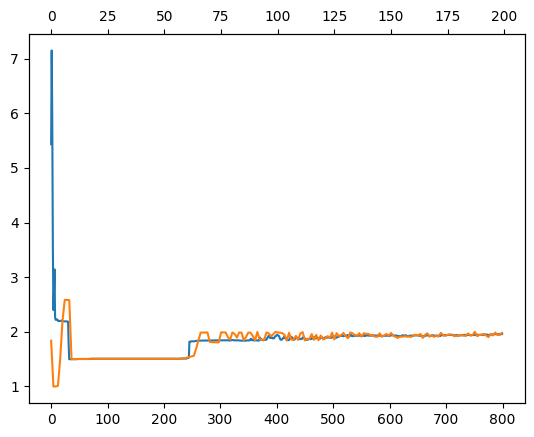

In [177]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(trainer.train_perp_record, label='train', color='tab:blue')
ax2 = ax1.twiny()
ax2.plot(trainer.valid_perp_record, label='valid', color='tab:orange')
plt.show()

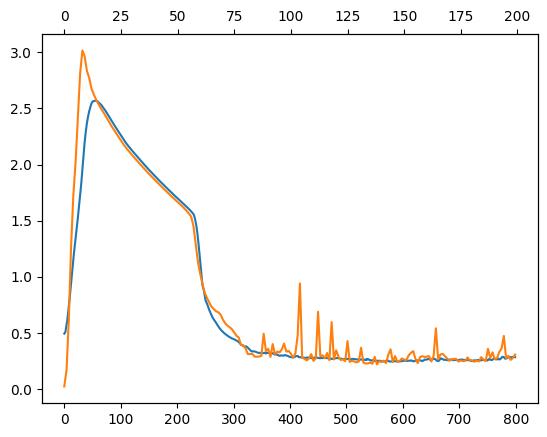

In [178]:
fig, ax1 = plt.subplots()
ax1.plot(trainer.train_vq_loss_record, label='train', color='tab:blue')
ax2 = ax1.twiny()
ax2.plot(trainer.valid_vq_loss_record, label='valid', color='tab:orange')
plt.show()

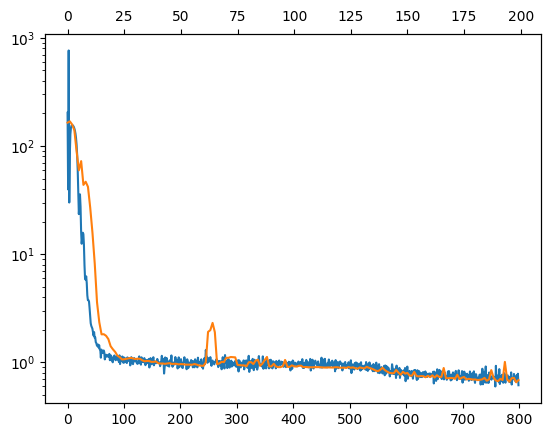

In [179]:
fig, ax1 = plt.subplots()
ax1.plot(trainer.train_recon_loss_record, label='train', color='tab:blue')
ax2 = ax1.twiny()
ax2.plot(trainer.valid_recon_loss_record, label='valid', color='tab:orange')
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.show()

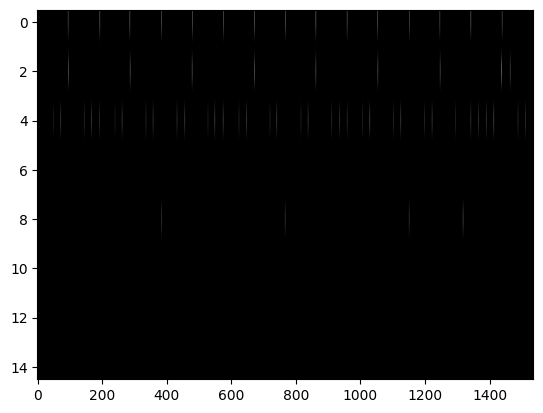

In [180]:
test_sample = torch.load('data/converted/105-dry13.pt')
plt.imshow(test_sample, cmap='gray', aspect='auto')

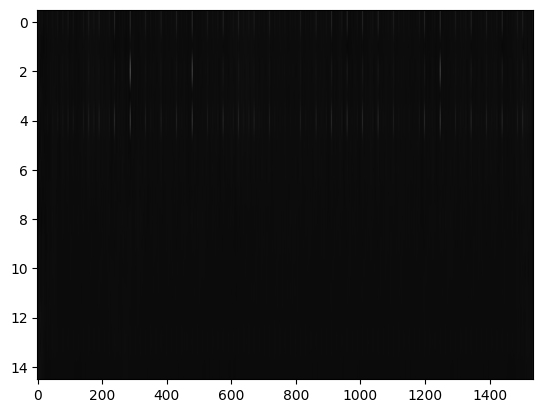

In [181]:
input = test_sample.unsqueeze(0).unsqueeze(0)

model.cpu()
model.eval()
with torch.inference_mode():
    recon, _, _ = model(input)

recon = recon.squeeze()
plt.imshow(recon, cmap='gray', aspect='auto')

In [185]:
test_sample.max()

tensor(0.3047)

In [184]:
recon.max()

tensor(0.2434)

In [187]:
threshold = 0.05
recon + 0.5

tensor([[ 0.4478,  0.0542,  0.0333,  ...,  0.0009,  0.0008,  0.0482],
        [ 0.0675, -0.0140,  0.0164,  ...,  0.0046, -0.0083,  0.0056],
        [ 0.0475,  0.0045, -0.0104,  ..., -0.0066,  0.0023,  0.0112],
        ...,
        [-0.0026,  0.0165,  0.0142,  ..., -0.0026, -0.0080,  0.0028],
        [ 0.1057,  0.0247,  0.0106,  ..., -0.0030, -0.0054,  0.0170],
        [ 0.0898,  0.0077,  0.0195,  ..., -0.0011, -0.0013,  0.0393]])

In [188]:
import mido

In [194]:
mid = mido.MidiFile()
mid.tracks.append(mido.MidiTrack())

threshold = 0.05
events = []
for tick, keys in enumerate((recon + 0.5).T):
    for key, velocity in enumerate(keys):
        if velocity > threshold:
            events.append([tick, key, int(velocity.item() * 127)])
            # events.append([tick+1, key, int(velocity.item() * 127), False])
            # mid.tracks[0].append(mido.Message('note_off', note=key, velocity=int(velocity * 127), time=tick))


In [196]:
for i in range(1, len(events)):
    events[i][0] -= events[i-1][0]

In [197]:
events

[[0, 0, 56],
 [0, 1, 8],
 [0, 4, 19],
 [0, 8, 9],
 [0, 13, 13],
 [0, 14, 11],
 [1, 0, 6],
 [95, 0, 8],
 [1, 4, 8],
 [111, 4, 6],
 [33, 4, 8],
 [127, 0, 12],
 [33, 4, 14],
 [159, 0, 12],
 [33, 4, 14],
 [207, 0, 23],
 [33, 4, 26],
 [255, 0, 35],
 [33, 2, 94],
 [255, 4, 50],
 [81, 0, 10],
 [255, 4, 12],
 [129, 0, 12],
 [255, 4, 14],
 [177, 0, 15],
 [255, 4, 17],
 [225, 0, 34],
 [255, 2, 67],
 [225, 4, 43],
 [303, 0, 8],
 [225, 4, 11],
 [351, 0, 21],
 [225, 4, 23],
 [399, 0, 15],
 [225, 4, 18],
 [431, 4, 6],
 [241, 0, 12],
 [431, 4, 14],
 [289, 0, 12],
 [431, 4, 13],
 [385, 0, 11],
 [431, 4, 12],
 [433, 0, 12],
 [431, 4, 14],
 [481, 0, 21],
 [431, 4, 24],
 [513, 4, 7],
 [447, 0, 26],
 [513, 2, 10],
 [447, 4, 27],
 [561, 0, 21],
 [447, 4, 24],
 [609, 0, 22],
 [447, 4, 23],
 [657, 0, 12],
 [447, 4, 13],
 [753, 0, 22],
 [447, 4, 24],
 [801, 0, 34],
 [447, 2, 67],
 [801, 4, 43],
 [495, 0, 8],
 [801, 4, 11],
 [543, 0, 22],
 [801, 4, 23],
 [591, 0, 12],
 [801, 4, 14],
 [639, 0, 26],
 [801, 2, 10